In [7]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification,BertConfig

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss

import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import pad_sequences

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Embedding


2023-09-19 15:18:40.311946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
config = BertConfig.from_pretrained('prajjwal1/bert-mini')
model = TFBertForSequenceClassification(config=config)


In [9]:
model.build()

In [10]:
model.load_weights("weights-bert.h5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'weights-bert.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
model.summary()

In [11]:
def hamming_loss(y_true, y_pred, threshold=0.5):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Apply the threshold to the predicted values
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)

 # Calculate the Hamming Loss\
    epsilon = 1e-7  # Small epsilon value\n",
    hamming_loss = 1.0 - tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=1) / (tf.reduce_sum(y_true + y_pred - y_true * y_pred, axis=1) + epsilon))

    return hamming_loss.numpy()

In [12]:
data_processed = pd.read_csv("../data/"+"labelling_dataset_v1.csv")
# Split into training and testing data
X = data_processed["text_processed"]
y = data_processed.drop(labels=["text_processed", "text"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

### Let's tokenize the vocabulary
tk = Tokenizer()
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index)

# We apply the tokenization to the train and test set
X_train_token = tk.texts_to_sequences(X_train)
X_test_token = tk.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post')

# Size of your embedding space = size of the vector representing each word
embedding_size = 50

# create the model
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_size))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.LSTM(100))
model.add(layers.Dense(6, activation='sigmoid'))

# Students will be ending their code here

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Change the number of epochs and the batch size depending on the RAM Size

es = EarlyStopping(patience=4, restore_best_weights=True)

model.fit(X_train_pad, y_train,
    epochs=150,
    batch_size=128,
    callbacks=[es], validation_split=0.3
)
res = model.evaluate(X_test_pad, y_test)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')
print('Testing loss \t', res[0]*100)
print('Testing accuracy ', res[1]*100)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          1958700   
                                                                 
 conv1d (Conv1D)             (None, None, 32)          4832      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 2017338 (7.70 MB)
Trainable params: 2017338 (7.70 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [13]:
y_true = y_test
y_pred=model.predict(X_test_pad)

h3 = hamming_loss(y_true, y_pred)
h3

442/442 [==============================] - 4s 8ms/step


0.45775944

In [16]:
data_processed = pd.read_csv("../data/"+"labelling_dataset_v1.csv")
# Split into training and testing data
X = data_processed["text_processed"]
y = data_processed.drop(labels=["text_processed", "text"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

### Let's tokenize the vocabulary
tk = Tokenizer()
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index)

# We apply the tokenization to the train and test set
X_train_token = tk.texts_to_sequences(X_train)
X_test_token = tk.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post')

# Size of your embedding space = size of the vector representing each word
embedding_size = 50


# Create the model
model = Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size+1, # size of the input, impacting the number of weights in the linear combinations of the neurons of the first layer
    output_dim=embedding_size, # 100
    mask_zero=True, # Built-in masking layer
))

model.add(layers.GRU(20, return_sequences=True, activation="tanh"))
model.add(layers.GRU(20, activation="tanh"))
model.add(layers.Dense(6, activation="sigmoid"))
model.summary()

model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

es = EarlyStopping(patience=4, restore_best_weights=True)

model.fit(X_train_pad, y_train,
        epochs=150,
        batch_size=128,
        callbacks=[es], validation_split=0.3
        )

res = model.evaluate(X_test_pad, y_test)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')
print('Testing loss \t', res[0]*100)
print('Testing accuracy ', res[1]*100)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          1958700   
                                                                 
 gru_2 (GRU)                 (None, None, 20)          4320      
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_2 (Dense)             (None, 6)                 126       
                                                                 
Total params: 1965666 (7.50 MB)
Trainable params: 1965666 (7.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
232/232 [==============================] - 31s 101ms/step - loss: 0.5314 - accuracy: 0.3501 - val_loss: 0.5129 - val_accuracy: 0.3574
Ep

In [17]:
y_true = y_test
y_pred=model.predict(X_test_pad)

h3 = hamming_loss(y_true, y_pred)
h3

442/442 [==============================] - 8s 12ms/step


0.46234578

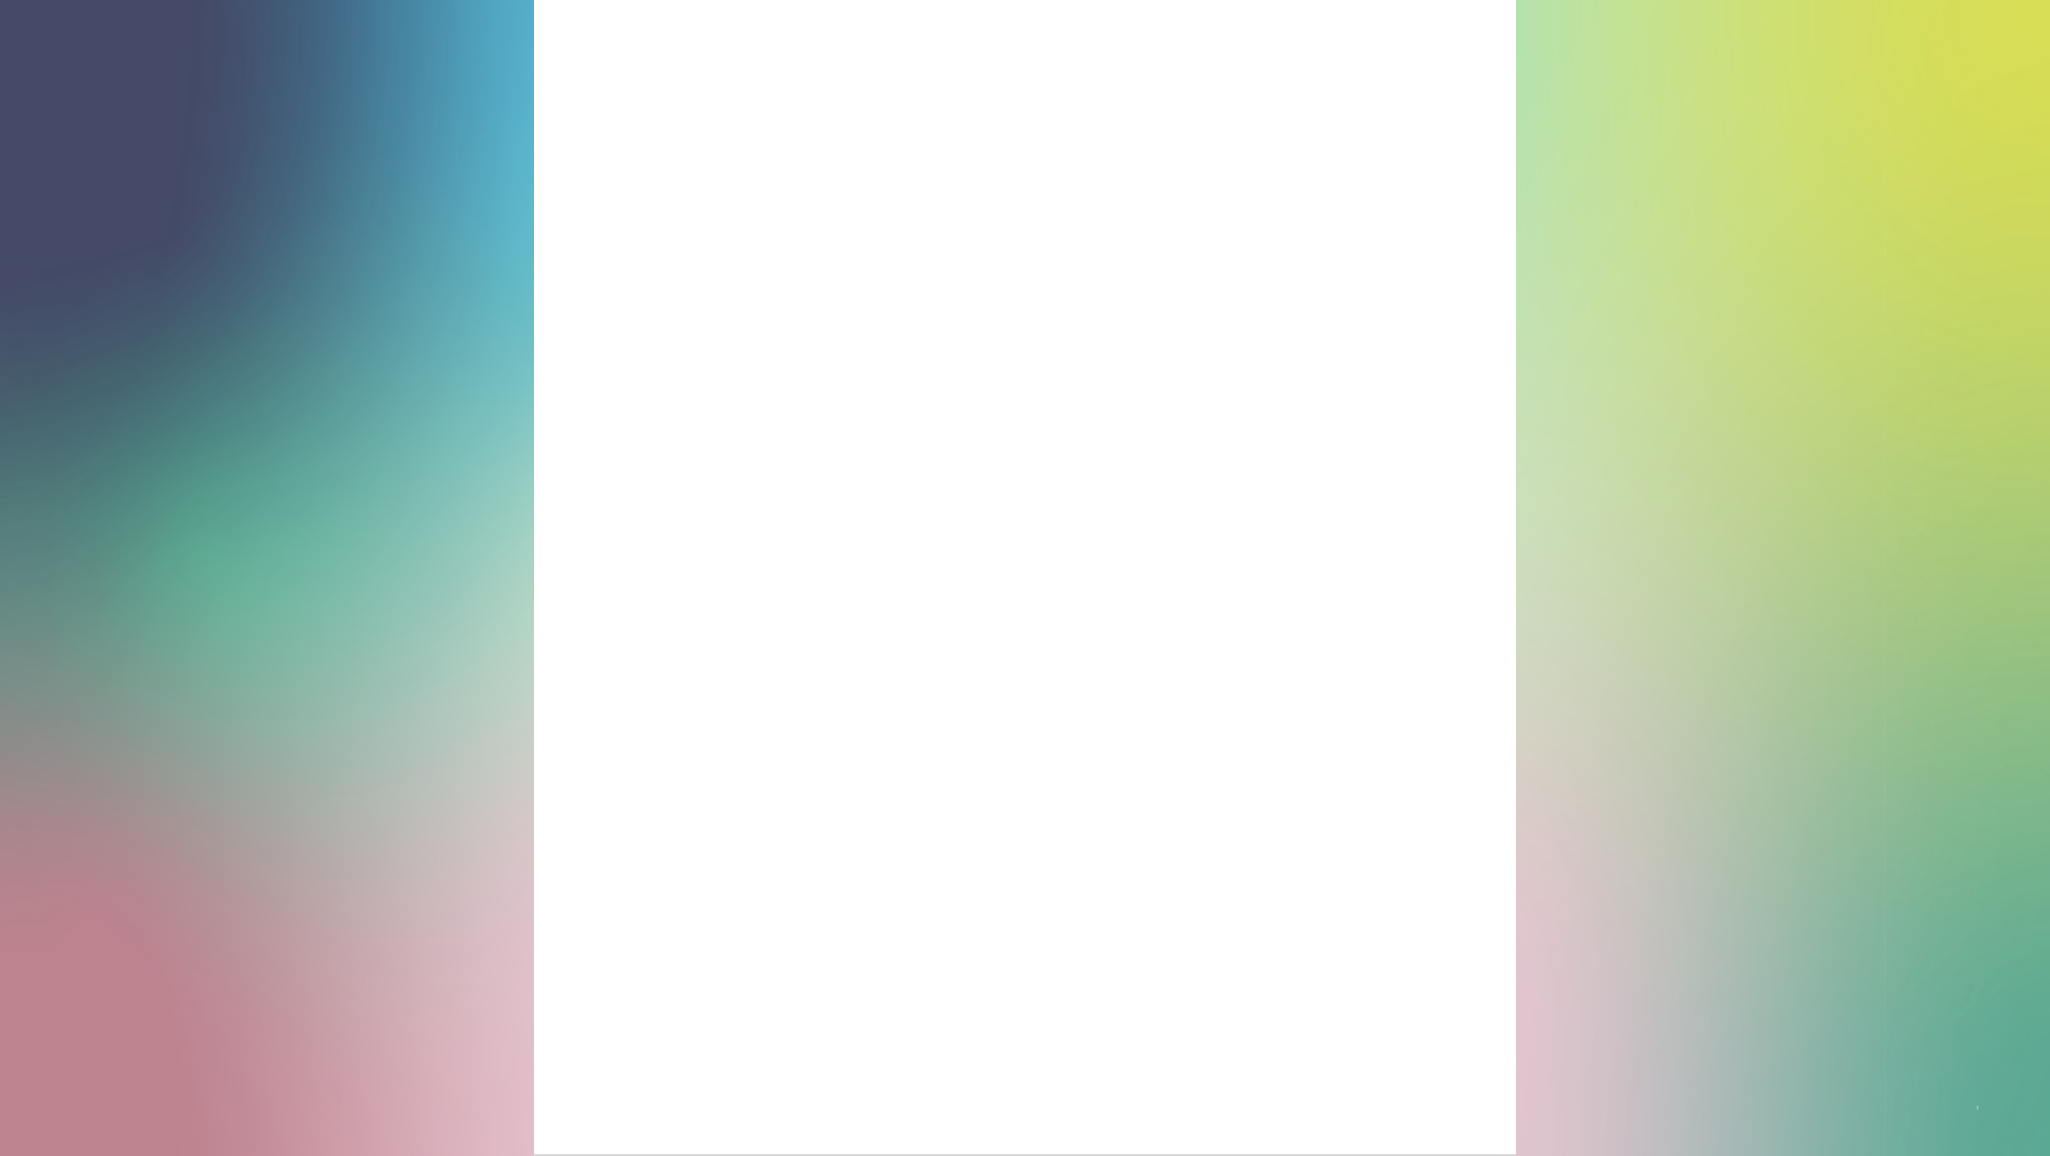

In [2]:
from PIL import Image
from IPython.display import display

# Load the image from a file
image = Image.open("../data/Background_site.png")  # Replace with the actual path to your image file

# Display the image
display(image)